#Install & Import Libraries


In [ ]:
## Install the necessary libraries
!pip3 install pydub
!pip3 install xmltodict
!pip3 install resemblyzer
!pip3 install pyannote.core
!pip3 install noisereduce
!pip3 install pyannote.metrics
!pip3 install python_speech_features
!pip3 install spectralcluster
!pip3 install hdbscan

     |████████████████████████████████| 15.7MB 176kB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72383 sha256=aca03a1092eaa5f9b51ed2db1ab22cc43f27728dbbbc8b2b87b0165e13d7c0f4
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
  Created wheel for typing: filename=typing-3.7.4.3-cp37-none-any.whl size=26308 sha256=db395b218d08f2bf005040b922cb2ed968817f8e7b34370a3a12690a4cb274d2
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
Successfully built webrtcvad typing


     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 133kB 7.5MB/s 
  Created wheel for noisereduce: filename=noisereduce-1.1.0-cp37-none-any.whl size=7610 sha256=48d7085d05ec840827f3f1f27898a9d62fdda4b8cfeaec20b89f9c20ece9478b
  Stored in directory: /root/.cache/pip/wheels/a6/2c/70/f9ccb41280dcfbe3eaeb7930f913dd85394617f3d3136f29cc
Successfully built noisereduce
     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=e43c0eb2c20089c26f772b1e9ddef33f81ef6ba5386570e50e33a13427c6e923
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features
     |████████████████████████████████| 6.4MB 6.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing

In [ ]:
## Mount Colab Drive To Load Dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## For importing code from drive
import sys
sys.path.append('/content/drive/MyDrive/ATML/code')

## Import Voice Activity Detector Model Functions from VAD
import VAD
from VAD import fxn, speech

## Import MFCC Feature Extractor from preprocess
import preprocess
from preprocess import *

## Import CNN Model Architecture from model
import model
from model import *

In [ ]:
from pydub import AudioSegment
import xmltodict
import os

## Import resemblyzer for library based pre-trained encoder 
from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path
import numpy as np

## Import necessary functions for parsing XML data files
from operator import itemgetter
from lxml import etree
import xml.etree.ElementTree as ET
import json

## Import librosa for processing wav files
import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display
from math import ceil

from pyannote.core import Segment, Timeline, Annotation, notebook
import noisereduce as nr
from tqdm import tqdm

## Import functions for manually computing mfcc features
from python_speech_features import fbank
from random import choice

import numpy as np

import matplotlib
from matplotlib import style
import datetime

In [ ]:
## Import necessary PyTorch for creating Dataset and Training CNN Model
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


# Data Preprocessing



In [ ]:
###################### PATH TO CORPUS & AUDIO FOLDER ######################
AMI_CORPUS_FOLDER = './drive/MyDrive/ATML/ami_public_manual_1.6.2/words'
AMI_CORPUS_FOLDER2 = './drive/MyDrive/amicorpusfinal/ami_public_manual_1.6.2/words'
AMI_AUDIO_FOLDER = './drive/MyDrive/ATML/amicorpus/'
AMI_AUDIO_FOLDER1 = './drive/MyDrive/amicorpus/'
AMI_AUDIO_FOLDER2 = './drive/MyDrive/amicorpusfinal/'
 
SPEAKERS = ['A', 'B', 'C', 'D']
X_FILENAME = 'X_withoutEmbedding.txt'
Y_FILENAME = 'y.txt'
TIME_FILENAME = 'startEndTime.txt'

## Set Threshold for VAD
THRESHOLD_VAD = 0

In [ ]:
## Define Functions for reading writing X and y vectors from AMI Corpus Datset

import pickle

def write(list1,filename):
  l = list1
  with open(filename, "wb") as fp:   #Pickling
    pickle.dump(l, fp)

def read(filename):
  with open(filename, "rb") as fp:   # Unpickling
    b = pickle.load(fp)
  return b

### Read Training Data


In [ ]:
'''
## Code to store X_withoutEmbedding (raw MFCC Features) startEndTime (corresponding Start-End Time) y (Speaker Label for Wav segment) in txt file
## Put file names in WORKING_RECORDING_IDS list to create text file

## Preprocess the RECORDING_ID and store the X_withoutEmbedding, startEndTime and y for each speech segment appropriately
def read_xml_and_split(RECORDING_ID,AMI_AUDIO_FOLDER):
  X_withoutEmbedding = []
  y = []
  startEndTime = []

  y_ref = []
  startEndTime_ref = []

  speakers_phrases = []
  for index, speaker in enumerate(SPEAKERS):
      t = parse_ami_transcript_xml(
          f"{AMI_CORPUS_FOLDER}/{RECORDING_ID}.{speaker}.words.xml", index)
      speakers_phrases.extend(t)
  
  final = sorted(speakers_phrases, key=itemgetter('start'))
  print(len(final))

  for i in range(len(final)):
    speaker = final[i]['speaker_id']
    startEndTime_ref.append([final[i]['start'],final[i]['end']])
    y_ref.append(speaker)

  for i in range(len(final)-1):
    if(final[i]['end']>final[i+1]['start']):
      final[i]['end']=final[i+1]['start']

  inverseWindowLength = 1 
  for i in range(len(final)):
    speaker = final[i]['speaker_id']
    for j in range(0,int(inverseWindowLength*(final[i]['end']-final[i]['start']))):
      split_wav(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio'),f'{RECORDING_ID}.Mix-Headset.wav',final[i]['start']+j/inverseWindowLength,final[i]['start']+(j+1)/inverseWindowLength,f'{speaker}_{i}_{j}')
      wav = sample_from_mfcc(read_mfcc(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio',f'{RECORDING_ID}.Mix-Headset_{speaker}_{i}_{j}.wav'), SAMPLE_RATE), NUM_FRAMES)
      X_withoutEmbedding.append(wav)
      # X.append(embed)
      y.append(speaker)
      startEndTime.append([final[i]['start']+j/inverseWindowLength,final[i]['start']+(j+1)/inverseWindowLength])
    
  write(X_withoutEmbedding,os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,X_FILENAME))
  write(startEndTime,os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,TIME_FILENAME))
  write(y,os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,Y_FILENAME))


IS = ['IS1000b', 'IS1001b', 'IS1002b', 'IS1003b', 'IS1004b', 'IS1005b', 'IS1006b', 'IS1007b', 'IS1008b', 'IS1009b']
TS = ['TS3003b', 'TS3004b', 'TS3005b', 'TS3006b', 'TS3007b', 'TS3008b', 'TS3009b', 'TS3010b', 'TS3011b', 'TS3012b']
ES = ['ES2002a', 'ES2004a', 'ES2005a', 'ES2006a', 'ES2006b', 'ES2007a', 'ES2009a', 'ES2010a', 'ES2011a', 'ES2012a']

WORKING_RECORDING_IDS = []
for id in WORKING_RECORDING_IDS:
  read_xml_and_split(id,AMI_AUDIO_FOLDER2)
'''

In [ ]:
# Code to read X_withoutEmbedding startEndTime y from txt file
# Put file names in WORKING_RECORDING_IDS list to get X_withoutEmbedding startEndTime y 

# List of file used in train, validation and testing
TRAIN_WORKING_RECORDING_IDS = ['IS1000b', 'IS1001b', 'IS1002b', 'IS1003b', 'IS1004b', 'IS1005b', 'IS1006b', 
                               'TS3003b', 'TS3004b', 'TS3005b', 'TS3006b', 'TS3007b', 'TS3008b', 'TS3009b',
                               'ES2002a', 'ES2004a', 'ES2005a', 'ES2006a', 'ES2006b', 'ES2007a', 'ES2009a']

VAL_WORKING_RECORDING_IDS = ['IS1007b', 'IS1008b',
                             'TS3010b', 'TS3011b',
                             'ES2010a', 'ES2011a']

TEST_WORKING_RECORDING_IDS = [ 'IS1009b',
                              'TS3012b',
                              'ES2012a']

# For Reading stored Data
def read_all(RECORDING_ID,AMI_AUDIO_FOLDER):
  X_withoutEmbedding = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,X_FILENAME))
  y = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,Y_FILENAME))
  startEndTime = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,TIME_FILENAME))
  return X_withoutEmbedding, y, startEndTime

# For modifying time so that time will not overlap of different file 
def modifyTime(startEndTime):
  temp = [0]
  for i in range(1,len(startEndTime)):
    if(startEndTime[i][0]<startEndTime[i-1][0]):
      temp.append(temp[i-1]+startEndTime[i-1][1])
    else:
      temp.append(temp[i-1]) 
  for i in range(len(startEndTime)):
    startEndTime[i][0] = startEndTime[i][0] + temp[i] 
    startEndTime[i][1] = startEndTime[i][1] + temp[i]
  return temp

# Appending all the x,y vectors to create single x,y vector list
def createFinalList(WORKING_RECORDING_IDS,AMI_AUDIO_FOLDER):values
  X_withoutEmbedding, y, startEndTime = read_all(WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER)
  for i in range(1,len(WORKING_RECORDING_IDS)):
    X_withoutEmbedding_temp, y_temp, startEndTime_temp = read_all(WORKING_RECORDING_IDS[i],AMI_AUDIO_FOLDER)
    ## modify y
    y_temp = [n + 4*i for n in y_temp]
    ## modify startEndTime
    startEndTime.extend(startEndTime_temp)
    modifyTime(startEndTime)
    X_withoutEmbedding.extend(X_withoutEmbedding_temp)
    y.extend(y_temp)
    
  return X_withoutEmbedding, y, startEndTime


### For DER Calculation
X_withoutEmbedding, y, startEndTime = read_all(TRAIN_WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER2)
X_withoutEmbedding_test, y_test, startEndTime_test = read_all(TEST_WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER2)

### Create Pytorch Dataset from Preprocessed Chunks + Labels


In [ ]:
## Reshape the MFCC Feature Dataset to Conform to CNN Input Shape

X_withoutEmbedding1 = [x.reshape((1, x.shape[0], x.shape[1])) for x in X_withoutEmbedding]

## Create Tensor Train Dataset and DataLoader 
tensor_x = torch.Tensor(X_withoutEmbedding1) # Transform to torch tensor
tensor_y = torch.Tensor(y)

my_dataset = TensorDataset(tensor_x,tensor_y) # Create custom datset
my_dataloader = DataLoader(my_dataset) # Create custom dataloader

## Do the Same for Test Dataset
X_withoutEmbedding_test1 = [x.reshape((1, x.shape[0], x.shape[1])) for x in X_withoutEmbedding_test]

tensor_x_test = torch.Tensor(X_withoutEmbedding_test1) # Transform to torch tensor
tensor_y_test = torch.Tensor(y_test)

my_dataset_test = TensorDataset(tensor_x_test, tensor_y_test) # Create custom datset
my_dataloader_test = DataLoader(my_dataset_test) # Create custom dataloader


# Create Embeddings using CNN Model

###Define CNN Architecture and Triplet Net Model


In [ ]:
## Base CNN Network for Encoding Speech MFCC Features into Embedding vector
class EmbeddingNet(nn.Module):

    ## Model Architecture
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)  # 3x3 Convoluion 2d
        self.pool1 = nn.MaxPool2d(2, stride=2)  # 2x2 MaxPool
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)  # 3x3 Convoluion 2d
        self.pool2 = nn.MaxPool2d(2, stride=2)  # 2x2 MaxPool

        self.fc1 = nn.Linear(1 * 40 * 16, 32) # 32 neurons large Fully Connected Layer 
        self.fc2 = nn.Linear(32, 16)  # 16 neurons large Fully Connected Layer 

    ## Model Forward Pass
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = x.view(-1, 1 * 40 * 16)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    ## Extract Embedding at Test Time
    def get_embedding(self, x):
        return self.forward(x)

## Triplet Network for Encoding Triples (Anchor, Positive, Negative) of Speech MFCC Features into Embedding vector
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3, []

    def get_embedding(self, x):
        return self.embedding_net(x)

### Create Custom Triplet Loss Function 

In [ ]:
## Compute Triplet Loss Function for 3 input Speech Segments w.r.t Speaker Label (Anchor, Positive, Negative) 

class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


### Create Custom Triplet Dataset to sample 3 samples (anchor, positive, negative) 

In [ ]:
class TripletDataset(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, data, targets):
        self.data = data

        self.targets = targets
        self.targets_sets = set(self.targets.numpy())
        self.targets_to_indices = {target: np.where(self.targets.numpy() == target)[0]
                                  for target in self.targets_sets}

    def __getitem__(self, index):

        data1, label1 = self.data[index], self.targets[index].item()

        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.targets_to_indices[label1])
        
        negative_label = np.random.choice(list(self.targets_sets - set([label1])))
        negative_index = np.random.choice(self.targets_to_indices[negative_label])
        data2 = self.data[positive_index]
        data3 = self.data[negative_index]

        return (data1, data2, data3), []

    def __len__(self):
        return len(self.targets)


In [ ]:
## Create Triplet Dataset Loader for 3 input Speech Segments w.r.t Speaker Label (Anchor, Positive, Negative) 
## This will be used during Model Training for fetching minibatch of samples

def TripletLoaderCreater(RECORDING_IDS,AMI_AUDIO_FOLDER):
    X_withoutEmbedding, y, _ = createFinalList(RECORDING_IDS,AMI_AUDIO_FOLDER)
    X_withoutEmbedding = [x.reshape((1, x.shape[0], x.shape[1])) for x in X_withoutEmbedding]
    tensor_x = torch.Tensor(X_withoutEmbedding)
    tensor_y = torch.Tensor(y)
    triplet_train_dataset = TripletDataset(tensor_x, tensor_y)
    batch_size = 16
    cuda = torch.cuda.is_available()
    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
    triplet_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    return triplet_loader

###Define Model Training Function

In [ ]:
def preloader_fit(triplet_train_loader, triplet_validation_loader, model, loss_fn, optimizer, global_epochs, cuda, log_interval, metrics=[]):

    ## Create lists to return Training and Validation Losses at each epoch
    validation_losses = []
    epoch_validation_losses = []
    epoch_train_losses = []

    ## Variables to record best performing model over the Validation Set
    best_validation_loss = 1e10
    best_epoch = 0

    ## Begin Training
    for epoch in range(global_epochs):

        ## Current Epoch Loss
        global_epoch_loss = 0

        ## Allow accumulating gradient to update weights
        model.train()

        for metric in metrics:
            metric.reset()

        losses = []
        total_loss = 0

        ## Iterate over the Triplet Train Dataset Loader
        for batch_idx, (data, target) in enumerate(triplet_train_loader):

            ## Check if samples fetch form triples (anchor, positive, negative). Else discard
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            ## Reset previously accumulated gradient
            optimizer.zero_grad()
            
            ## Compute output over current batch
            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)

            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            ## Compute Triplet Loss over current batch
            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            losses.append(loss.item())
            total_loss += loss.item()

            ## Update Model Parameters
            loss.backward()
            optimizer.step()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

            ## Print Progress over mini-batches
            if batch_idx % log_interval == 0:
                message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    batch_idx * len(data[0]), len(triplet_train_loader.dataset),
                    100. * batch_idx / len(triplet_train_loader), np.mean(losses))
                for metric in metrics:
                    message += '\t{}: {}'.format(metric.name(), metric.value())

                print(message)
                losses = []


        ## Update current global eppoch loss      
        global_epoch_loss = total_loss

        ## Print Train Loss Computed over the current epoch
        global_epoch_loss = global_epoch_loss/len(TRAIN_WORKING_RECORDING_IDS)

        message = '\nGlobal Epoch: {}/{}. Average loss: {:.4f}\n'.format(epoch + 1, global_epochs, global_epoch_loss)
          
        print(message)

        ## Append train losses occured in each epoch to track progress
        epoch_train_losses.append(global_epoch_loss)


        ## Compute Validation Loss
        total_validation_loss = 0

        ## Freeze weights and prevent any gradient accumulation over the validation set
        with torch.no_grad():
            model.eval()

            ## Iterate over the Triplet Validation Dataset Loader
            for batch_idx, (data, target) in enumerate(triplet_validation_loader):

                    ## Check if samples fetch form triples (anchor, positive, negative). Else discard
                    target = target if len(target) > 0 else None
                    if not type(data) in (tuple, list):
                        data = (data,)
                    if cuda:
                        data = tuple(d.cuda() for d in data)
                        if target is not None:
                            target = target.cuda()

                    ## Compute output over current batch
                    outputs = model(*data)

                    if type(outputs) not in (tuple, list):
                        outputs = (outputs,)

                    loss_inputs = outputs
                    if target is not None:
                        target = (target,)
                        loss_inputs += target

                    ## Compute Triplet Loss over current batch
                    loss_outputs = loss_fn(*loss_inputs)
                    loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
                    validation_losses.append(loss.item())
                    total_validation_loss += loss.item()
                    
                    for metric in metrics:
                        metric(outputs, target, loss_outputs)

            ## Print Validation Loss Computed over the current epoch
            validation_message = 'Epoch: {}/{}. Validation set: loss: {:.4f}'.format(epoch + 1, global_epochs, total_validation_loss)
            for metric in metrics:
                validation_message += '\t{}: {}'.format(metric.name(), metric.value())

            print(validation_message)

            ## Append validation losses occured in each epoch to track progress
            epoch_validation_losses.append(total_validation_loss)


            ## Keep track of best performing model till yet and save its weights
            if(total_validation_loss < best_validation_loss):

                torch.save(model.state_dict(), './drive/MyDrive/CNN/ami_epoch:{}_loss:{}_trial_abc.pt'.format(epoch+1, total_validation_loss))
                best_validation_loss = total_validation_loss
                best_epoch = epoch


            best_validation_message = 'Epoch: {}/{}, Validation set: Best_loss: {:.4f}'.format(best_epoch + 1, global_epochs, best_validation_loss)
            for metric in metrics:
                best_validation_message += '\t{}: {}'.format(metric.name(), metric.value())

            print(best_validation_message)

    ## Return the train and validation losses for each epoch during training
    return losses,epoch_train_losses, epoch_validation_losses

In [ ]:
## Define Model Hyperparameters

cuda = torch.cuda.is_available()

batch_size = 16
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

margin = 0.5
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
n_epochs = 5
log_interval = 100

global_epochs = 50

In [ ]:
## Create Triplet Train and Validation Loader
triplet_train_loader = TripletLoaderCreater(TRAIN_WORKING_RECORDING_IDS,AMI_AUDIO_FOLDER2)
triplet_validation_loader = TripletLoaderCreater(VAL_WORKING_RECORDING_IDS,AMI_AUDIO_FOLDER2)

## Call Training Function
losses,epoch_train_losses, epoch_validation_losses = preloader_fit(triplet_train_loader, triplet_validation_loader, model, loss_fn, optimizer, global_epochs, cuda, log_interval)

Train: [0/20164 (0%)]	Loss: 7.966187
Train: [1600/20164 (8%)]	Loss: 7.947466
Train: [3200/20164 (16%)]	Loss: 7.869937
Train: [4800/20164 (24%)]	Loss: 7.409695
Train: [6400/20164 (32%)]	Loss: 6.762743
Train: [8000/20164 (40%)]	Loss: 6.640448
Train: [9600/20164 (48%)]	Loss: 6.332714
Train: [11200/20164 (56%)]	Loss: 6.131905
Train: [12800/20164 (63%)]	Loss: 6.177964
Train: [14400/20164 (71%)]	Loss: 5.778294
Train: [16000/20164 (79%)]	Loss: 5.673688
Train: [17600/20164 (87%)]	Loss: 5.709218
Train: [19200/20164 (95%)]	Loss: 5.941925

Global Epoch: 1/50. Average loss: 390.4530

Epoch: 1/50. Validation set: loss: 1588.4585
Epoch: 1/50, Validation set: Best_loss: 1588.4585
Train: [0/20164 (0%)]	Loss: 5.009153
Train: [1600/20164 (8%)]	Loss: 5.857837
Train: [3200/20164 (16%)]	Loss: 5.463225
Train: [4800/20164 (24%)]	Loss: 5.917161
Train: [6400/20164 (32%)]	Loss: 5.861074
Train: [8000/20164 (40%)]	Loss: 5.430886
Train: [9600/20164 (48%)]	Loss: 5.325961
Train: [11200/20164 (56%)]	Loss: 5.539969
Tr

[390.4530096905572, 333.0261828274954, 316.637010369982, 303.8173692169644, 296.8212792532785, 293.02715204301336, 286.0314099334535, 285.5068674513272, 275.91939923876805, 276.934324656214, 275.1906673681168, 266.2414500060536, 266.9053381993657, 261.0795796769006, 263.19709713827996, 253.94687965512276, 258.4591344027292, 257.7353144969259, 251.25484328752472, 248.69344302586146, 247.43346895632288, 246.909710110653, 241.65293175549735, 243.81162341719582, 239.22663482030234, 241.14475712038222, 242.51372623159773, 240.14139728035246, 238.0620393100239, 237.3642774025599, 233.57834493262428, 237.77087900894028, 232.31492070215089, 231.1217605499994, 234.69851323110717, 233.30424986282983, 232.55153651180723, 227.81714712154297, 230.33259658444496, 230.3209713002046, 228.45740204056105, 228.23101737669535, 227.51009443544206, 228.23156200562204, 223.42498275779542, 226.20236117783048, 226.70547285392172, 222.35709369466417, 225.43573929582323, 223.54368143989927] [1588.4585171937943, 

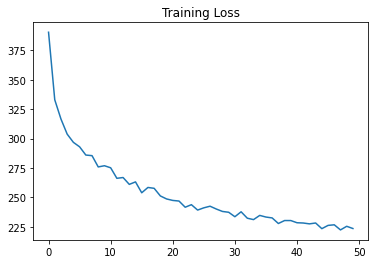

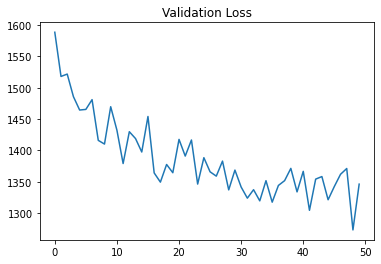

In [ ]:
## Plot Training and Validtion Loss for the CNN Embedder
print(epoch_train_losses,epoch_validation_losses)
# epoch_train_losses,epoch_validation_losses = [77.37873827956972, 68.58136124497369, 65.63913824615027, 63.4119617703415, 62.276457815794714, 60.686017280533214, 58.834863289481106, 58.56412758827208, 57.40883635282516, 56.70930422998613, 54.852105906463805, 54.44819284280141, 53.68102415800095, 53.768498914014735, 52.062647401435036, 52.57142420524644, 50.87011056457248, 50.82263183111237, 49.93972813061305, 48.908816092354904, 49.33027262233552, 48.657839692774274, 48.5257597826776, 48.33135527996791, 47.765749564341135, 46.675640346890404, 46.66294175868943, 45.92313934564591, 45.608668460448584, 45.7869643205688, 45.28143299221992, 45.37059381547429, 45.55935424906866, 44.526569897787915, 44.34714434232031, 44.11037120393345, 43.464860957860935, 44.02078930962653, 43.09121095452989, 42.76774062344006, 43.471704876139064, 42.734028257926305, 42.342836804900855, 42.85073563201086, 43.002706900664734, 42.17005640438625, 42.28259157623563, 41.92199212369465, 42.483661425965174, 42.14613053174246] [260.62114238739014, 230.95112494627634, 215.5536606311798, 214.07172838846842, 206.5149898727735, 199.8792555232843, 198.5565283894539, 195.07991180817285, 184.6334692041079, 178.99775099754333, 170.77787458896637, 161.26192357142767, 166.19029861191908, 155.3291259855032, 150.69878348211446, 148.00650120774904, 145.13129970431328, 142.28367321689925, 138.84863617519537, 137.31055601437888, 138.48729613423347, 129.4326963921388, 137.19275395572186, 136.1583917836348, 128.87046014765897, 134.79161863029003, 129.37107210357985, 127.58525161445141, 127.87921431660652, 126.37029408911864, 123.7037332803011, 129.41618982950845, 124.71776561439037, 128.01760370035967, 122.23488933841388, 121.121378749609, 124.57182816167672, 122.27665382126968, 121.20896982153256, 114.52970705429713, 117.01875400543213, 117.53469532728195, 115.41225211819012, 115.63621984918912, 119.57949425280094, 113.14574781060219, 114.68423809607823, 111.06180823345979, 110.264464199543, 110.36583456397057]
plt.title("Training Loss")
plt.plot( epoch_train_losses)
plt.show()

plt.figure()
plt.title("Validation Loss")
plt.plot( epoch_validation_losses)
plt.show()

In [ ]:
'''
## Uncomment the following lines to load our pretrained model 

torch.save(model.state_dict(), './drive/MyDrive/trial_abc.pt')
!ls ./drive/MyDrive/
print(os.getcwd())
print(os.listdir())
model.load_state_dict(torch.load('./drive/MyDrive/CNN/ami_epoch:10_loss:229.08540630340576_trial_abc.pt'))
'''

"\n## Uncomment the following lines to load our pretrained model \ntorch.save(model.state_dict(), './drive/MyDrive/trial_abc.pt')\n!ls ./drive/MyDrive/\nprint(os.getcwd())\nprint(os.listdir())\nmodel.load_state_dict(torch.load('./drive/MyDrive/CNN/ami_epoch:10_loss:229.08540630340576_trial_abc.pt'))"

###Used Trained Model to Extract Embedding for Wav chunks

In [ ]:
## Define functions to extract embedding for the Training Set and Test Set Speech Segments

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 16))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

def extract_embeddings_test(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 16))
        # labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images in dataloader:
            if cuda:
                images = images.to(device)
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            k += len(images)
    return embeddings

In [ ]:
train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True, **kwargs)
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)

In [ ]:
test_loader = torch.utils.data.DataLoader(my_dataset_test, batch_size=batch_size, shuffle=True, **kwargs)
test_embeddings_tl, test_labels_tl = extract_embeddings(test_loader, model)

In [ ]:
## Extract Embeddings
X, y = np.array(train_embeddings_tl), np.array([int(i) for i in train_labels_tl])
X_test, y_test =  np.array(test_embeddings_tl), np.array([int(i) for i in test_labels_tl])

# Cluster Plot of Embeddings

####PCA for Dataset Emebeddings (with True Labels)


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA

def preprocessingX(X):
  # Preprocessing the data to make it visualizable 
  raw_df = pd.DataFrame(X)  

  # Scaling the Data 
  scaler = StandardScaler() 
  X_scaled = scaler.fit_transform(raw_df) 

  # Normalizing the Data 
  X_normalized = preprocessing.normalize(X_scaled) 

  # Converting the numpy array into a pandas DataFrame 
  X_normalized = pd.DataFrame(X_normalized) 

  # Reducing the dimensions of the data 
  pca = PCA(n_components = 2) 
  X_principal = pca.fit_transform(X_normalized) 
  X_principal = pd.DataFrame(X_principal) 
  X_principal.columns = ['P1', 'P2'] 
  return X_principal
  
X_principal = preprocessingX(X)
# X_principal_test = preprocessingX(X_test)
X_principal.head(2) 

,P1,P2
0,0.070299,-0.553835
1,0.161604,0.671281


###Plot of Spectral Clustering When exact number of speakers known

####Using Radial Basis Function 


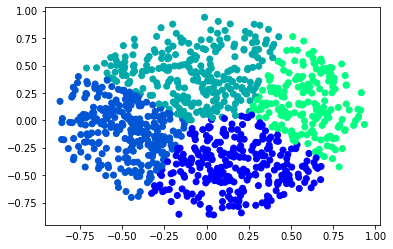

In [ ]:
from spectralcluster import SpectralClusterer
from sklearn.cluster import SpectralClustering

# Building the clustering model 
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity ='rbf') 

# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(X_principal)

# Visualizing the clustering
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = SpectralClustering(n_clusters = 4, affinity ='rbf') .fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

####Using Nearest Neighbours function

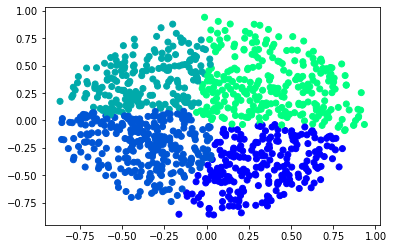

In [ ]:
# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(X_principal)

# Visualizing the clustering 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') .fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

###Plot of Spectral Clustering When number of speaker not known beforehand


### Scatter Plot with True Labels as color vector (4 clusters -> 4 speakers)

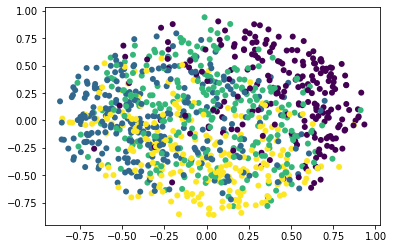

In [ ]:
c = np.random.choice(range(4), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal['P1'], X_principal['P2'], c=y, lw=0)

#### Using Spectral Clustering Algorithm

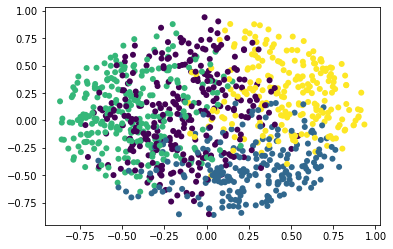

In [ ]:
clusterer1 = SpectralClusterer(
    min_clusters=4,
    max_clusters=100,
    p_percentile=0.95,
    gaussian_blur_sigma=0.25)

labels1 = clusterer1.predict(X)
labels_test1 = clusterer1.predict(X_test)

c = np.random.choice(range(4), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal['P1'], X_principal['P2'], c=labels1, lw=0)

#### Using Agglomerative Heirarchical Clustering Function

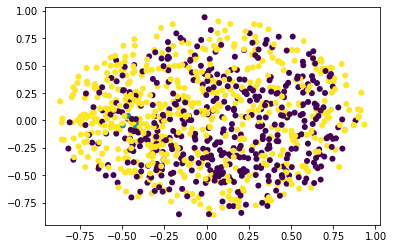

In [ ]:
import hdbscan

clusterer2 = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=4, min_samples=None, p=None)

clusterer2.fit(X)
labels2 = clusterer2.labels_

clusterer2.fit(X_test)
labels_test2 = clusterer2.labels_

c = np.random.choice(range(4), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal['P1'], X_principal['P2'], c=labels2, lw=0)

# Make Predictions Using Embeddings

### Calculate Diarization Error Rate (DER) values

In [ ]:
## Create Helper Fucntions to Compute DER

from pyannote.metrics.diarization import DiarizationErrorRate, GreedyDiarizationErrorRate, JaccardErrorRate

## Compute Speeker Segments from Model output
def get_hypothesis(speaker_segments):
    hypothesis = Annotation()
    for t in speaker_segments:
        try:
            hypothesis[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_hyp"
        except:
            pass
        
    return hypothesis

## Compute Speeker Segments from Ground Truth
def get_ref(speaker_segments):
    reference = Annotation()
    for t in speaker_segments:
        try:
            reference[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_ref"
        except:
            pass
        
    return reference

der = DiarizationErrorRate()
gder = GreedyDiarizationErrorRate()
jer = JaccardErrorRate()

## Compute DER
def measure_metrics(reference, hypothesis):
    der_value = der(reference, hypothesis)
    print('DER:', der_value)

    
    return der_value

In [ ]:
## Compute Speaker Start End Time Segments

def ref_hypo(startEndTime,startEndTime_ref,labels,y):
  speaker_segments = []
  for i in range(len(startEndTime)):
    speaker_segments.append({
                        'start': startEndTime[i][0],
                        'end': startEndTime[i][1],
                        'speaker_id': labels[i]
                    })
  speaker_segments_ref = []
  for i in range(len(startEndTime_ref)):
    speaker_segments_ref.append({
                        'start': startEndTime_ref[i][0],
                        'end': startEndTime_ref[i][1],
                        'speaker_id': y[i]
                    })
  return speaker_segments,speaker_segments_ref

labels = labels1
# labels = labels2

labels_test = labels_test1
# labels_test = labels_test2

speaker_segments,speaker_segments_ref = ref_hypo(startEndTime,startEndTime,labels,y)
speaker_segments_test,speaker_segments_ref_test = ref_hypo(startEndTime_test,startEndTime_test,labels_test,y_test)

In [ ]:
## DER over a sample Train File

hypothesis = get_hypothesis(speaker_segments)
reference = get_ref(speaker_segments_ref)
der_value = measure_metrics(reference, hypothesis)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


DER: 0.42357642357642356


In [ ]:
## DER over an unknown Test File

hypothesis_test = get_hypothesis(speaker_segments_test)
reference_test = get_ref(speaker_segments_ref_test)
der_value = measure_metrics(reference_test, hypothesis_test)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


DER: 0.47536945812807874


### Visualise Overall Diarization Outcome 

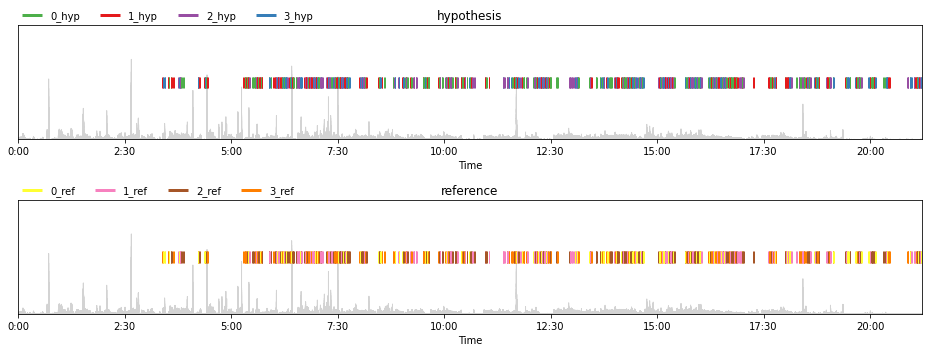

In [ ]:
## Visualise Model Outputs as compared against the Ground Truth

def timeTicks(x, pos):
    d = datetime.timedelta(seconds=x)
    return str(d)[-5:] if x < 3600 else str(d)
formatter = matplotlib.ticker.FuncFormatter(timeTicks)

SR = 32000

def plot_der(FILEPATH,reference,hypothesis):
    fig = plt.figure(figsize=(13, 5))

    # plot hypothesis
    ax = plt.subplot(211)
    plt.title('hypothesis')
    ax.xaxis.set_major_formatter(formatter)
    wav, source_sr = librosa.load(FILEPATH, sr=SR)
    ticks_freq = ceil(len(wav) * .1 / source_sr)

    notebook.plot_annotation(hypothesis, legend=True, time=True)
    librosa.display.waveplot(wav, sr=source_sr, color='lightgray')

    # plot reference
    ax = plt.subplot(212)
    plt.title('reference')
    ax.xaxis.set_major_formatter(formatter)

    notebook.plot_annotation(reference, legend=True, time=True)
    librosa.display.waveplot(wav, sr=source_sr, color='lightgray')

    plt.margins(x=0.01)
    plt.tight_layout()
    plt.show()

%matplotlib inline


plot_der(os.path.join(os.path.join(AMI_AUDIO_FOLDER2,'ES2002a','audio'),'ES2002a.Mix-Headset.wav'),reference,hypothesis)

